# Persistence diagrams from biased ensembles
This script makes the plots involving biased ensembles.

In [1]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import single_flip_contiguous
import numpy as np
import operator
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import pickle
import sys, os
import networkx as nx
from collections import defaultdict
import tdaredistricting as tdar

## Load in the shapefile data
The PA shapefile used here is available along with many others at github.com/mggg-states. The election_names and election_columns have to be changed when changing from PA to a different state.

In [2]:
#updaters
election_names = ["PRES16", "SEN16", "ATG12", "GOV14", "GOV10", "PRES12", "SEN10", "ATG16", "SEN12"]
election_columns = [
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["USS12D", "USS12R"]
] #DEM, REP
pop_tol = 0.02
pop_col = "TOTPOP"
myupdaters = {
    "population": updaters.Tally(pop_col, alias="population"),
}
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
myupdaters.update(election_updaters)
allparts = {}
allgraphs = {}

In [3]:
gdf = gpd.read_file("PA_VTD_PLANS/PA_VTD_PLANS.shp")
graph = Graph.from_json("PA_VTD.json")

In [4]:
gdf = gdf.to_crs({"init":"epsg:2271"})

/opt/miniconda3/envs/work311/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Compute biased persistence diagrams

You need to run `TDA_PAintoN_bias.py` first to generate the graphs and partitions.

In [5]:
folder = "Mar23PAbiased" #this is where the output of the ReCom run is
graphsDEM = pickle.load(open(folder+"/graphs50_Democratic.p", "rb"))
graphsREP = pickle.load(open(folder+"/graphs50_Republican.p", "rb"))

/var/folders/l3/2v7x5klx521_b__wr6yk92_00000gp/T/ipykernel_57927/3622895646.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='Mar23PAbiased/graphs50_Democratic.p'>
  graphsDEM = pickle.load(open(folder+"/graphs50_Democratic.p", "rb"))
/var/folders/l3/2v7x5klx521_b__wr6yk92_00000gp/T/ipykernel_57927/3622895646.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='Mar23PAbiased/graphs50_Republican.p'>
  graphsREP = pickle.load(open(folder+"/graphs50_Republican.p", "rb"))


In [6]:
seatsDEM = []
for g, w in graphsDEM["PRES16"]:
    seatsDEM.append(
        len([x for x in w if x > 0.5])
    )
seatsREP = []
for g, w in graphsREP["PRES16"]:
    seatsREP.append(
        len([x for x in w if x > 0.5])
    )

In [7]:
e = "PRES16"
DEMPDs = []
REPPDs = []
for g, w in graphsDEM[e]:
    PD = tdar.persistence_diagram_from_graph(
        g,sorted(w)
    )
    PD[-1] = (PD[-1][0], 1)
    PD = sorted(PD, key=lambda x: x[1]-x[0])
    DEMPDs.append(PD)
for g, w in graphsREP[e]:
    PD = tdar.persistence_diagram_from_graph(
        g,sorted(w)
    )
    PD[-1] = (PD[-1][0], 1)
    PD = sorted(PD, key=lambda x: x[1]-x[0])
    REPPDs.append(PD)

In [8]:
#seeds set based on trying every possible starting point
#you can either leave seed blank to pick randomly, or use Frechet_mean_reseed for robust but slow results
biasedmeans = {}
biasedmeans["DEM"] = tdar.Frechet_mean(DEMPDs, seed=714) 
biasedmeans["REP"] = tdar.Frechet_mean(REPPDs, seed=817)

## Plot Frechet means next to each other (no matching)

We can plot the two Frechet means next to each other on the same persistence diagram.

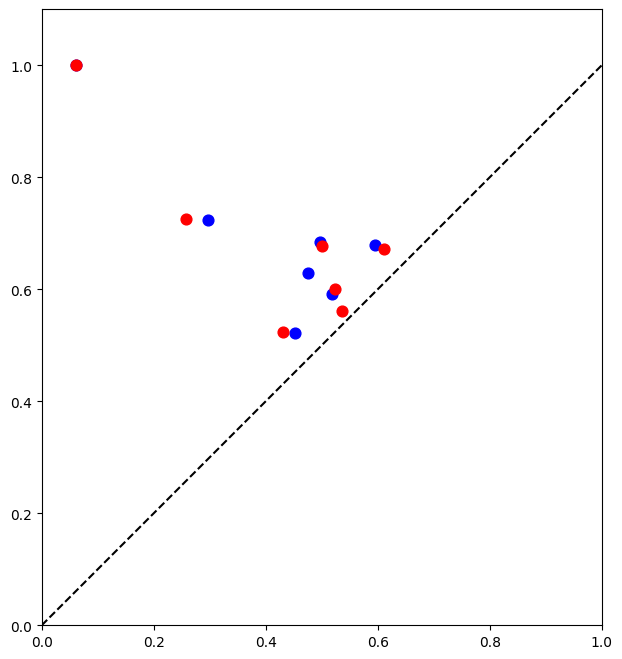

In [9]:
biasedmeans["DEM"] = sorted(biasedmeans["DEM"], key=lambda x: x[1]-x[0], reverse=True)
biasedmeans["REP"] = sorted(biasedmeans["REP"], key=lambda x: x[1]-x[0], reverse=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    [x[0] for x in biasedmeans["DEM"][:7]],
    [x[1] for x in biasedmeans["DEM"][:7]],
    c='b',s=60
)
ax.scatter(
    [x[0] for x in biasedmeans["REP"][:7]],
    [x[1] for x in biasedmeans["REP"][:7]],
    c='r',s=60
)
ax.set_xlim(0,1)
ax.set_ylim(0,1.1)
ax.set_aspect('equal')
ax.plot([0,1],[0,1], linestyle='dashed', color='black')

## Plot Frechet means with best persistence matching

We can match the points in the two Frechet means by solving the 2-Wasserstein problem. This might not correspond to the geographic matching you would get by looking at the map. If you know the geographic matching, you can hard-code it and adapt the code below to pair up points which are geographically similar.

In [10]:
match = tdar.match_Hungarian(biasedmeans["REP"], biasedmeans["DEM"])

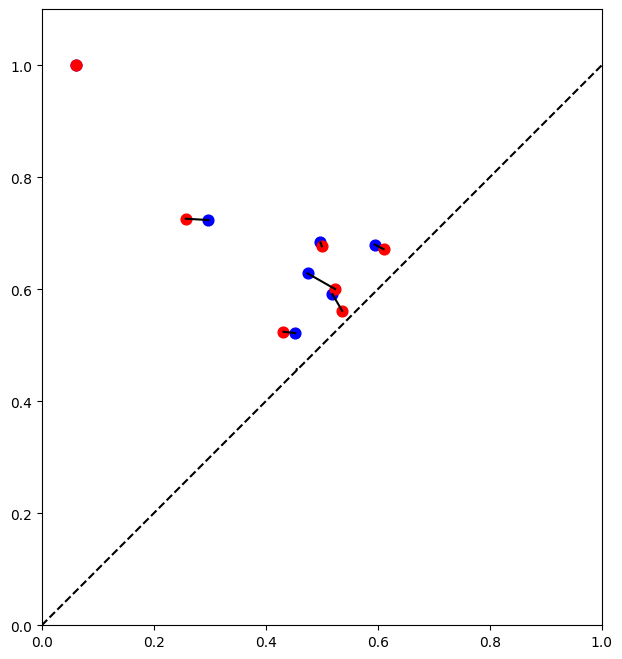

In [11]:
biasedmeans["DEM"] = sorted(biasedmeans["DEM"], key=lambda x: x[1]-x[0], reverse=True)
biasedmeans["REP"] = sorted(biasedmeans["REP"], key=lambda x: x[1]-x[0], reverse=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    [x[0] for x in biasedmeans["DEM"][:7]],
    [x[1] for x in biasedmeans["DEM"][:7]],
    c='b',s=60
)
ax.scatter(
    [x[0] for x in biasedmeans["REP"][:7]],
    [x[1] for x in biasedmeans["REP"][:7]],
    c='r',s=60
)
for i, x in enumerate(biasedmeans["DEM"]):
    #non diagonal matched to non diagonal
    if len(x) > 1 and len(match[i]) > 1:
        ax.plot(
            [x[0], match[i][0]],
            [x[1], match[i][1]],
            c='black'
        )

ax.set_xlim(0,1)
ax.set_ylim(0,1.1)
ax.set_aspect('equal')
ax.plot([0,1],[0,1], linestyle='dashed', color='black')